# Part 3 ‑ Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later, we consider a user retained if they were "active" (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention (again, a few sentences will suffice).

Data description:
* city: city this user signed up in
* phone: primary device for this user
* signup_date: date of account registration, in the form "YYYY MM DD"
* last_trip_date: the last time this user completed a trip, in the form "YYYY MM DD"
* avg_dist: the average distance in miles per trip taken in the first 30 days after signup
* avg_rating_by_driver: the rider's average rating over all of their trips
* avg_rating_of_driver: the rider's average rating of their drivers over all of their trips
* surge_pct: the percent of trips taken with surge multiplier > 1
* avg_surge: The average surge multiplier over all of this user's trips
* trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
* ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days, FALSE otherwise
* weekday_pct: the percent of the user's trips occurring during a weekday

----

We will try to respond to these questions by performing the exploratory data analysis (EDA) and modeling the customer retention as a classification problem with Logistic Regression, Random Forest and gradient boosting (LightGBM) models. We will study feature importance evaluated with these models, which we will optimize usng the area under the ROC curve score, convenient for maximazing the true to false positive (retention) ratio.

## 1. Data wrangling, EDA, Feature Engineering

Let's load libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl # colors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from datetime import datetime as dt
import pickle

plt.rcParams['axes.grid'] = True
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.xmargin'] = 0.02
plt.rcParams['axes.ymargin'] = 0.1
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True

plt.rcParams['figure.figsize'] = (10.0, 5.0)
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

and read in the data:

In [2]:
df = pd.read_json("data/ultimate_data_challenge.json")
df

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.0,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5


In [3]:
df.shape

(50000, 12)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


We have two datetime-type features, which were not automatically recognized by pandas as such. Let's convert them to the datetime format now:

In [5]:
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'] )
df['signup_date'] = pd.to_datetime(df['signup_date'] )

In [6]:
df.dtypes

city                              object
trips_in_first_30_days             int64
signup_date               datetime64[ns]
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date            datetime64[ns]
phone                             object
surge_pct                        float64
ultimate_black_user                 bool
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
dtype: object

OK. Let's plot the time information, i.e. the histograms with the distribution of the signup date and the date of the last trip:

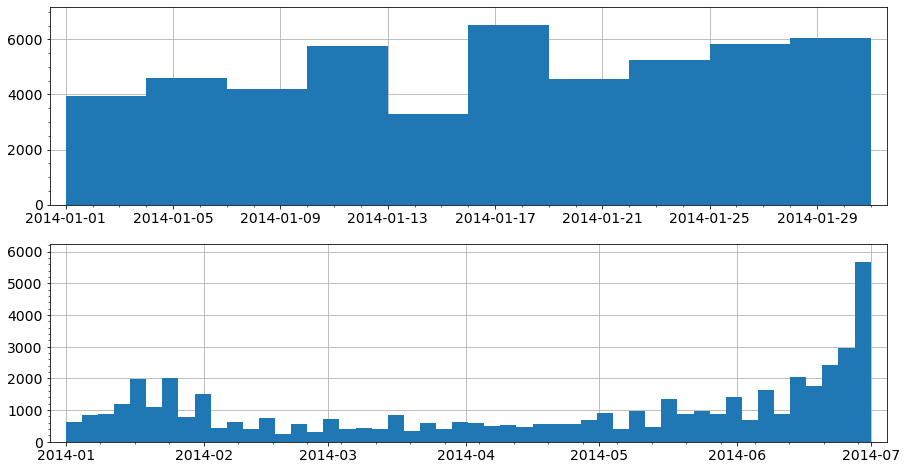

In [7]:
fig, ax = plt.subplots(2,1,figsize=(15,8))

df['signup_date'].hist(bins=10,ax=ax[0])
df['last_trip_date'].hist(bins=50,ax=ax[1]);

As stated in the problem description, the signup date spans the time of one month, January 2014, and the last trip date is within the first 6 months of 2014. Time to construct the retention rate. A user is considered "retained" if his last trip took place within the last 30 days covered in the dataset. What exactly is the latest date?: 

In [8]:
print(df['last_trip_date'].max())

2014-07-01 00:00:00


July 1, so our cut off for the retained users should be set to June 1, 2014. 

Let's create a column with a binary information (retained or not) and check what's the rate of retained users:

In [9]:
df['target'] = np.where(df['last_trip_date'] >= '2014-06-01',1,0)
df[['last_trip_date','target']].head()

,last_trip_date,target
0,2014-06-17,1
1,2014-05-05,0
2,2014-01-07,0
3,2014-06-29,1
4,2014-03-15,0


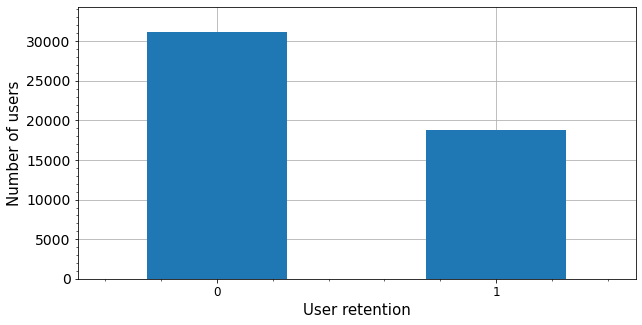

In [10]:
df['target'].value_counts().plot.bar()

plt.ylabel('Number of users',fontsize=15)
plt.xlabel('User retention',fontsize=15)
plt.xticks(rotation=0,fontsize=12);

In [11]:
tv = pd.concat([df['target'].value_counts(),df['target'].value_counts(normalize=True)*100],axis=1)
tv.columns =['N. of users', '% of total']
tv.round(1)

,N. of users,% of total
0,31196,62.4
1,18804,37.6


18.8k out of the total of 50k users (37.6%) are retained (active over the last 30 days).

OK, good. Do we need the datetime columns at this point? Doesn't seem like we do, so let's remove them from the dataset:

In [12]:
df = df.drop(['signup_date','last_trip_date'],axis=1)
df.head()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,target
0,King's Landing,4,4.7,1.10,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,5.0,1.00,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,4.3,1.00,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,4.6,1.14,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,4.4,1.19,Android,11.8,False,82.4,3.13,4.9,0


Let's focus on the features now. Let's start with addressing the missing values:

In [13]:
miss_vals = pd.concat((df.isna().sum(),(df.isna().sum()/df.shape[0]*100).round(2)),axis=1)
miss_vals.columns = ['N of missing','% of total']
miss_vals

,N of missing,% of total
city,0,0.00
trips_in_first_30_days,0,0.00
avg_rating_of_driver,8122,16.24
avg_surge,0,0.00
phone,396,0.79
surge_pct,0,0.00
ultimate_black_user,0,0.00
weekday_pct,0,0.00
avg_dist,0,0.00
avg_rating_by_driver,201,0.40


Three out of 12 features contain missing values, these are average ratings given to and by a driver (16.2 and 0.4 %, respecively), and the customer's phone type (0.8%). As for ratings, we can assume that customers who were extremely happy or unhappy with the service spoke up and left the feedback, and that the ratings for the missing values are close to average. We will replace these missing values by the feature average value for the entire sample:

In [14]:
for col in ['avg_rating_of_driver','avg_rating_by_driver']:
    df[col] = df[col].fillna(df[col].mean())

For the phone type, let's check what is the average retention rate for the subsample of users with missing phone info:

In [15]:
df[df['phone'].isna()]['target'].mean().round(2)

0.34

34% compared to 38% for the entire sample. Not a dramatic difference, so instead of guessing and subsituting the missing value for this categorical variable, let's remove the users who didn't give the phone info (0.4% of total, which should not affect our study of feature importance).

In [16]:
df = df.dropna()

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    49604 non-null  object 
 1   trips_in_first_30_days  49604 non-null  int64  
 2   avg_rating_of_driver    49604 non-null  float64
 3   avg_surge               49604 non-null  float64
 4   phone                   49604 non-null  object 
 5   surge_pct               49604 non-null  float64
 6   ultimate_black_user     49604 non-null  bool   
 7   weekday_pct             49604 non-null  float64
 8   avg_dist                49604 non-null  float64
 9   avg_rating_by_driver    49604 non-null  float64
 10  target                  49604 non-null  int64  
dtypes: bool(1), float64(6), int64(2), object(2)
memory usage: 4.2+ MB


OK, no more missing values, we're good now. What above feature unique values?:

In [18]:
df.nunique()

city                         3
trips_in_first_30_days      59
avg_rating_of_driver        38
avg_surge                  115
phone                        2
surge_pct                  367
ultimate_black_user          2
weekday_pct                664
avg_dist                  2902
avg_rating_by_driver        28
target                       2
dtype: int64

Summarizing the two printouts above, our dataset consists of:
- 3 categorical features with only 3 or 2 unique values (city, phone, ultimate_black_user), and 
- 7 numerical features, with about 30 to 3,000 unique values. 

Let's plot these features. Let's show them separately for the customers who retained (yellow) and customers who churned (blue), after normalizing the distributions to the total number of events in each sample. This way, we can compare the shapes of the distributions to find those that differ the most.

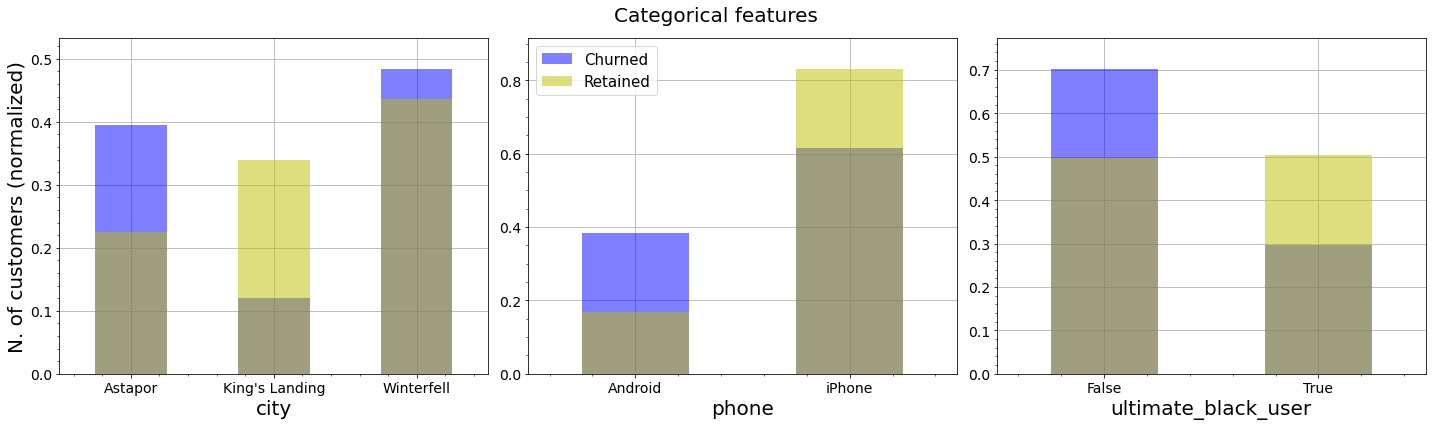

In [19]:
fig, ax = plt.subplots(1,3,figsize=(20,6))

for i,col in enumerate(df.drop('target',axis=1).select_dtypes(include=['object','bool'])):
    
    norm0 = df[df['target']==0][col].count()
    norm1 = df[df['target']==1][col].count()
    (df[df['target']==0].groupby(col)[col].count()/norm0).plot(kind='bar',ax=ax[i],color='b',alpha=0.5,label='Churned')
    (df[df['target']==1].groupby(col)[col].count()/norm1).plot(kind='bar',ax=ax[i],color='y',alpha=0.5,label='Retained')
    
    ax[i].set_xlabel(col);ax[i].tick_params(axis='x', labelrotation=0)
    ax[i].set_ylabel("")
    if i==0: ax[i].set_ylabel("N. of customers (normalized)")
        
ax[1].legend(fontsize=15)
fig.suptitle('Categorical features',fontsize=20)
fig.tight_layout()

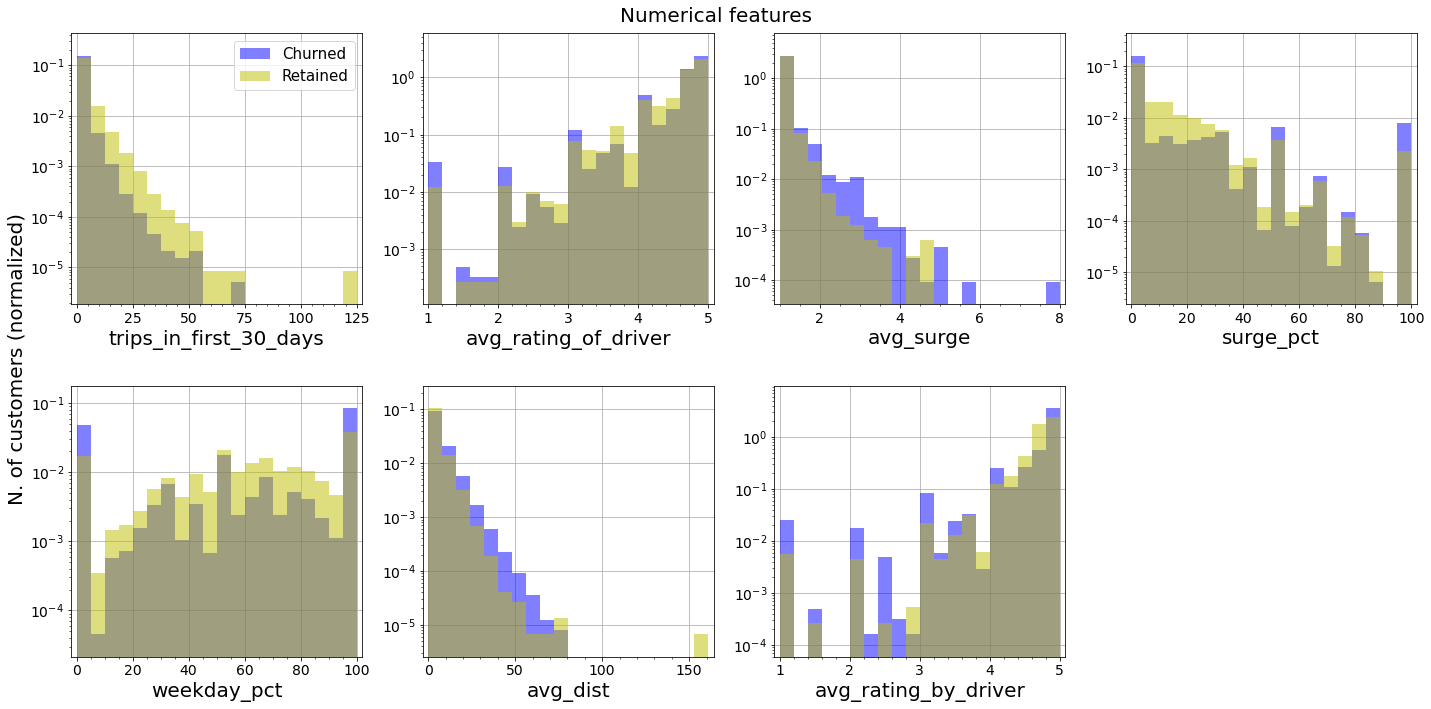

In [20]:
fig, ax = plt.subplots(2,4,figsize=(20,10))

ax = ax.ravel()
ax[7].set_axis_off()

for i,col in enumerate(df.drop('target',axis=1).select_dtypes(include=['int','float'])):
    
    r = (df[col].min(),df[col].max()); b = 20
    
    df[df['target']==0][col].plot(kind='hist',density=True,ax=ax[i],range=r,bins=b,color='b',alpha=0.5,label='Churned')
    df[df['target']==1][col].plot(kind='hist',density=True,ax=ax[i],range=r,bins=b,color='y',alpha=0.5,label='Retained')
    ax[i].set_yscale('log')
    
    ax[i].set_xlabel(col)
    ax[i].set_ylabel("")
    if i==4: ax[i].set_ylabel("N. of customers (normalized)",position=(0,1.1))
        
ax[0].legend(fontsize=15)
fig.suptitle('Numerical features',fontsize=20)
fig.tight_layout()

There are some clear trends, e.g. iPhone users, Ultimate Black users and customers from the city of King's Landing are more likely to retain, as well as those who took more trips over the last 30 days, whose average surge and average distance was lover, or those who didn't travel exclusively in the weekdays or weekends. Let's see if we will arrive at the same conclusions when studying the feature importance prediceted by the machine learning models.

Before doing so, we need to convert the categorical features to the numerical ones. Let's order them in the increasing order of the retained/churned ratio:

In [21]:
df['city']  = df['city'].replace(['Astapor','Winterfell',"King's Landing"],[0,1,2])
df['phone'] = df['phone'].replace(['Android','iPhone'],[0,1])
df['ultimate_black_user'] = df['ultimate_black_user'].replace([False, True],[0,1])

df.head()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,target
0,2,4,4.7,1.10,1,15.4,1,46.2,3.67,5.0,1
1,0,0,5.0,1.00,0,0.0,0,50.0,8.26,5.0,0
2,0,3,4.3,1.00,1,0.0,0,100.0,0.77,5.0,0
3,2,9,4.6,1.14,1,20.0,1,80.0,2.36,4.9,1
4,1,14,4.4,1.19,0,11.8,0,82.4,3.13,4.9,0


In [22]:
X = df.drop('target',axis=1)
y = df['target'].values

X.shape,y.shape

((49604, 10), (49604,))

Good, the dataset is ready for the modeling step. 

## 2. Modeling

Let's load the relevant libraries:

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

and let's run the three models: Logistic Regression (LR), Random Forest (RF) and Gradient Boosting (LightGBM) models. The comparison of the performance of LR relative to RF and LightGBM will give us hints on how non-linear the problem is. We will draw conclusions about feature importance on customer retention using the latter two models. We expect a similar performance for both of them, with perhaps slightely better score for the gradient boosting model. Comparison of two models will reduce the randomness in the modeling, and will give us a more robust insight into feature relevance.

### 2.1 Logistic Regression model

Let's scale the data, and split it into train and test subsamples (75%/25%):

In [24]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
X_train,X_test,y_train,y_test = train_test_split(X_scaled,y,test_size=0.25,random_state=123)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((37203, 10), (37203,), (12401, 10), (12401,))

In [25]:
%%time
lr = LogisticRegression(penalty='l1',solver='saga',max_iter=1000,random_state=123)
    
print(np.logspace(-3,3,7))
grid = {'C': np.logspace(-3,3,7)}
    
lr_grid_cv = GridSearchCV(lr,param_grid=grid,scoring='roc_auc',return_train_score=True,cv=3,n_jobs=-1)
lr_grid_cv.fit(X_train, y_train)

print("Best Parameters: " + str(lr_grid_cv.best_params_))
print("Best Score:"  + str(round(lr_grid_cv.best_score_,3)))

coef = pd.Series(lr_grid_cv.best_estimator_.coef_[0], index = X.columns)

[1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03]
Best Parameters: {'C': 1000.0}
Best Score:0.758
CPU times: user 345 ms, sys: 162 ms, total: 507 ms
Wall time: 2.54 s


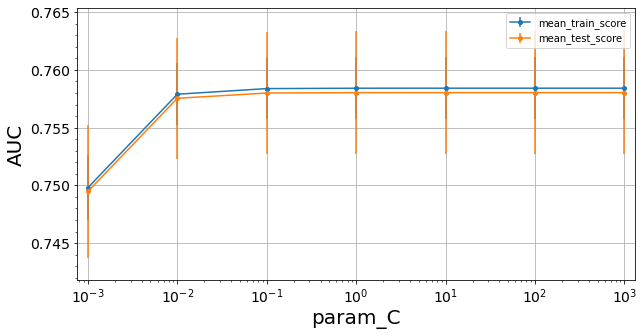

In [26]:
lr_results = pd.DataFrame(lr_grid_cv.cv_results_)
ax = lr_results.plot('param_C','mean_train_score',yerr='std_train_score',marker='o',markersize=4)
lr_results.plot('param_C','mean_test_score',yerr='std_test_score',marker='o',markersize=4,ax=ax)
plt.xscale("log")
ax.set_ylabel('AUC');

### 2.2 Random Forest model

Here we do not need to scale the data. Let's split the original dataset into the train and test subsamples (75%/25%):

In [27]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=123)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((37203, 10), (37203,), (12401, 10), (12401,))

In [28]:
%%time
rf = RandomForestClassifier(random_state=123)

grid = {'n_estimators': [100,200,500],
        'max_depth': [10,20,50]}

rf_grid_cv = GridSearchCV(rf,param_grid=grid,scoring='roc_auc',return_train_score=True,cv=3,n_jobs=-1)
        
rf_grid_cv.fit(X_train, y_train)
        
print("Best Parameters: " + str(rf_grid_cv.best_params_))
print("Best Score:"  + str(round(rf_grid_cv.best_score_,3)))

rf_fi = pd.Series(rf_grid_cv.best_estimator_.feature_importances_, index=X.columns)

Best Parameters: {'max_depth': 10, 'n_estimators': 500}
Best Score:0.85
CPU times: user 8.35 s, sys: 27 ms, total: 8.37 s
Wall time: 48.4 s


### 2.3 Gradient boosting, LightGBM model

In [29]:
%%time
lgb = LGBMClassifier(random_state=123)

grid = {'boosting_type': ['gbdt','dart'],
        'n_estimators': [100, 200, 500],
        'learning_rate': [0.01, 0.1, 0.5],
        'num_leaves': [16, 32, 64]}

lgb_grid_cv = GridSearchCV(lgb,param_grid=grid,scoring='roc_auc',return_train_score=True,cv=3,n_jobs=-1)
        
lgb_grid_cv.fit(X_train, y_train)
        
print("Best Parameters: " + str(lgb_grid_cv.best_params_))
print("Best Score:"  + str(round(lgb_grid_cv.best_score_,3)))   

lgb_fi = pd.Series(lgb_grid_cv.best_estimator_.feature_importances_, index=X.columns)

Best Parameters: {'boosting_type': 'dart', 'learning_rate': 0.1, 'n_estimators': 500, 'num_leaves': 32}
Best Score:0.858
CPU times: user 53.2 s, sys: 391 ms, total: 53.6 s
Wall time: 2min 37s


## 3. Summary

Let's plot the feature importance for each of the three cosidered models:

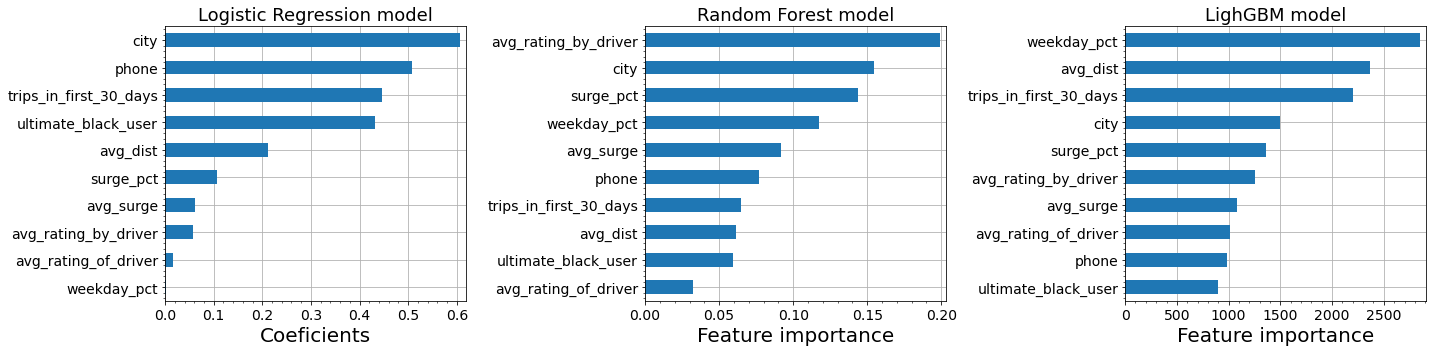

In [30]:
fig, ax = plt.subplots(1,3,figsize=(20,5))

coef.abs().sort_values().plot.barh(ax=ax[0])
ax[0].set_title('Logistic Regression model',fontsize=18); ax[0].set_xlabel('Coeficients')

rf_fi.sort_values().plot.barh(ax=ax[1])
ax[1].set_title('Random Forest model',fontsize=18); ax[1].set_xlabel('Feature importance')

lgb_fi.sort_values().plot.barh(ax=ax[2])
ax[2].set_title('LighGBM model',fontsize=18); ax[2].set_xlabel('Feature importance')

fig.tight_layout()

What can we say about them? Firstly, the results for the Logistic Regression (LR) are significantly different from those of ensamble models. This is expected for the case where the target dependence on the features is highly non linear. In fact, the LR model favors features than have the least number of unique values (categorical features with 2 or 3 unique values, to which it is easy to fit a straight logit line) or the features with a monotonically changing retained-to-churned ratio (trips_in_first_30_days, avg_surge, avg_dist). This bias of "linearity" is the reason why LR model obtained the worse score of the area under the ROC curve (0.76). A takeaway from the comparison is that our customer retention problem is highly non-linear.

The comparsion between the results of Random Forest and LightGBM looks more consistent. Among the 5 most important features for each model, 3 are common. These are: city, surge_pct, and weekday_pct. If we were to favor the LightGBM model, which gives the highest performance score of 0.86, we should also conclude that the retention depends strongly on the avg_dist and trips_in_the_first_30_days variables. On the other hand, the Random Forest results suggest that the average_rating_by_driver is the most important feature.

In order to improve the customer retention rate, we recommend to Ultimate to focus on parameters such as:
* the average surge multiplier over all of this user's trips (the lower multiplier favors higher retention)
* the percent of the trips occurring during a weekday (trips taken exclusively on weekends or week days have higher customer churn),
* average distance traveled in each ride in the first 30 days (shorter trips favor higher retention), and
* number of rides in the first 30 days (more rides favor higher retention),
* average rating by driver (higher rating indicate higher retention, so listen to your drivers :).